In [1]:
import numpy as np
from dataclasses import dataclass
from typing import List
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set()

In [6]:
@dataclass
class Obj:
    idx: int
    pos: np.array
    vel: np.array
    accel: np.array
    force: np.array
    connected_objs: List = None
    mass: float = 1.0
    energy: float = 0.0

In [7]:
K = 5
EQUILIBRIUM_LENGTH = 1.0
DT = 0.0002

In [8]:
def force(pos1: np.array, pos2: np.array):
    """pos2の物体からpos1の物体に働くフックの法則による力"""
    dist = np.sqrt(((pos1-pos2)**2).sum())
    r_normed = (pos2-pos1)/dist
    equilibrium_vec = EQUILIBRIUM_LENGTH*r_normed
    f = -K*(equilibrium_vec-(pos2-pos1))
    return f

In [9]:
force(
    np.random.randn(3), np.random.randn(3)
)

array([ 0.44184834, -1.36617483,  1.40923006])

In [23]:
def init_objs_2d():
    objs = {}
    # 物体作成
    for i in range(4):
        for j in range(4):
            objs[(i,j)] = Obj(
                idx=i*4+j,
                pos=np.array([i, j])+0.05*np.random.randn(2),
                vel=0.01*np.random.randn(2),
                #vel=np.zeros(2),
                accel=np.zeros(2),
                force=np.zeros(2),
            )

    # バネ連結情報付与
    for i in range(4):
        for j in range(4):
            connected_objs = []
            if i-1 >= 0:
                connected_objs.append(objs[(i-1,j)])
            if i+1 <= 3:
                connected_objs.append(objs[(i+1,j)])
            if j-1 >= 0:
                connected_objs.append(objs[(i,j-1)])
            if j+1 <= 3:
                connected_objs.append(objs[(i,j+1)])

            objs[(i,j)].connected_objs = connected_objs
    return objs

In [24]:
def _update_force_on_obj(obj: Obj):
    """物体に働く力の更新"""
    forces = [force(obj.pos, obj2.pos) for obj2 in obj.connected_objs]
    obj.force = sum(forces)

In [25]:
def _update_accel(obj: Obj):
    """物体の加速度更新"""
    obj.accel = obj.force / obj.mass

In [26]:
def _update_velocity(obj: Obj):
    """物体の速度更新"""
    obj.vel = obj.vel + DT*obj.accel

In [27]:
def _update_pos(obj: Obj):
    """物体の位置更新"""
    obj.pos = obj.pos + DT*obj.vel

In [28]:
def _calc_energy(obj: Obj):
    """物体の力学的エネルギー更新"""
    energy = 0.5*obj.mass*(obj.vel**2).sum()
    for obj2 in obj.connected_objs:
        dist = np.sqrt(((obj.pos-obj2.pos)**2).sum())
        r_normed = (obj2.pos-obj.pos)/dist
        equilibrium_vec = EQUILIBRIUM_LENGTH*r_normed
        energy += 0.5*0.5*K*((equilibrium_vec-(obj2.pos-obj.pos))**2).sum()
    obj.energy = energy

In [29]:
def update_states(objs: List[Obj]):
    """全物体の状態更新"""
    [_update_force_on_obj(obj) for obj in objs.values()]
    [_update_accel(obj) for obj in objs.values()]
    [_update_velocity(obj) for obj in objs.values()]
    [_update_pos(obj) for obj in objs.values()]
    [_calc_energy(obj) for obj in objs.values()]

In [99]:
def plot_objs_2d(objs: List[Obj]):
    xs = [obj.pos[0] for obj in objs.values()]
    ys = [obj.pos[1] for obj in objs.values()]
    plt.scatter(xs, ys, s=100)
    for obj in objs.values():
        plt.arrow(x=obj.pos[0],y=obj.pos[1],dx=obj.force[0],dy=obj.force[1],width=0.01,head_width=0.05,head_length=0.05,length_includes_head=True,color='red')
        plt.arrow(x=obj.pos[0],y=obj.pos[1],dx=obj.vel[0],dy=obj.vel[1],width=0.01,head_width=0.05,head_length=0.05,length_includes_head=True,color='green')
        for obj2 in obj.connected_objs:
            plt.plot([obj.pos[0], obj2.pos[0]], [obj.pos[1], obj2.pos[1]], linestyle='dashed', linewidth=0.5, color='black')
    plt.show()

In [112]:
def output_gif(system_state, objs, filepath, fps=50):
    sec_per_frame = 1/fps

    fig = plt.figure()
    ims_list = []
    relative_t = 0
    for i, t in enumerate(system_state['t']):
        delta_t = t - relative_t
        if delta_t < sec_per_frame:
            continue
        ims = []
        relative_t = t
        xs = [system_state['objs'][obj.idx]['pos'][i][0] for obj in objs.values()]
        ys = [system_state['objs'][obj.idx]['pos'][i][1] for obj in objs.values()]
        ims.append(plt.scatter(xs, ys, s=100))
        for obj in objs.values():
            pos = system_state['objs'][obj.idx]['pos'][i]
            vel = system_state['objs'][obj.idx]['vel'][i]
            force = system_state['objs'][obj.idx]['force'][i]
            ims.append(plt.arrow(x=pos[0],y=pos[1],dx=force[0],dy=force[1],width=0.01,head_width=0.05,head_length=0.05,length_includes_head=True,color='red'))
            ims.append(plt.arrow(x=pos[0],y=pos[1],dx=vel[0],dy=vel[1],width=0.01,head_width=0.05,head_length=0.05,length_includes_head=True,color='green'))
            for obj2 in obj.connected_objs:
                pos2 = system_state['objs'][obj2.idx]['pos'][i]
                ims += plt.plot([pos[0], pos2[0]], [pos[1], pos2[1]], linestyle='dashed', linewidth=0.5, color='black')
        ims_list.append(ims)
    ani = animation.ArtistAnimation(fig, ims_list, interval=100, blit=True, repeat_delay=1000)
    ani.save(filepath, writer="pillow")
    plt.show()

In [92]:
def record_system_state(t, objs, system_state):

    if 't' not in system_state:
        system_state['t'] = []
    system_state['t'].append(t)

    if 'objs' not in system_state:
        system_state['objs'] = {}
    for obj in objs.values():
        if obj.idx not in system_state['objs']:
            system_state['objs'][obj.idx] = {}
            system_state['objs'][obj.idx]['pos'] = []
            system_state['objs'][obj.idx]['vel'] = []
            system_state['objs'][obj.idx]['accel'] = []
            system_state['objs'][obj.idx]['force'] = []
        system_state['objs'][obj.idx]['pos'].append(obj.pos)
        system_state['objs'][obj.idx]['vel'].append(obj.vel)
        system_state['objs'][obj.idx]['accel'].append(obj.accel)
        system_state['objs'][obj.idx]['force'].append(obj.force)

    if 'energy' not in system_state:
        system_state['energy'] = []
    enrgy = sum([obj.energy for obj in objs.values()])
    system_state['energy'].append(enrgy)

In [93]:
objs = init_objs_2d()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)])

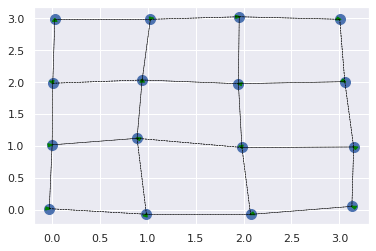

In [95]:
plot_objs_2d(objs)

In [76]:
from fastprogress import progress_bar as pb

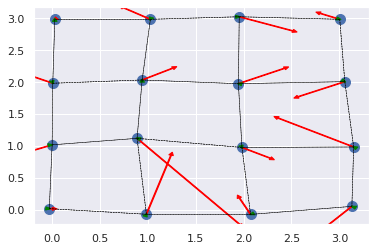

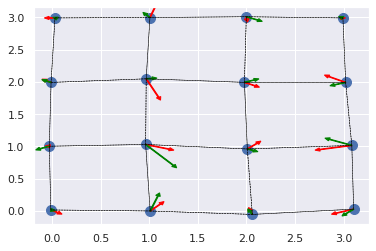

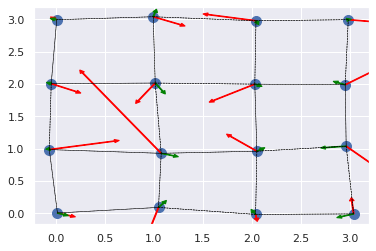

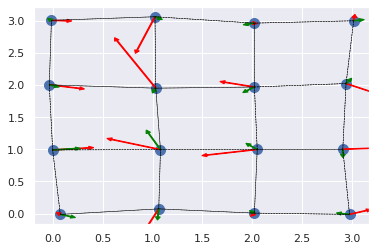

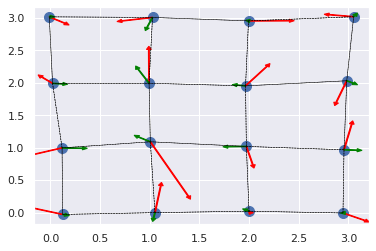

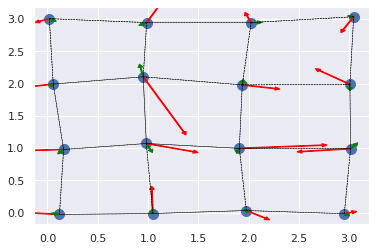

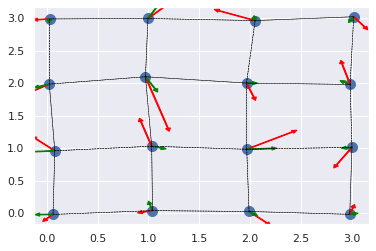

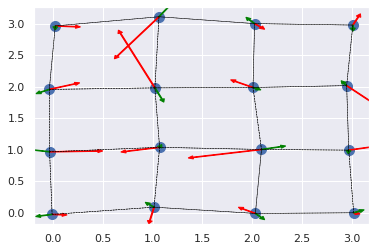

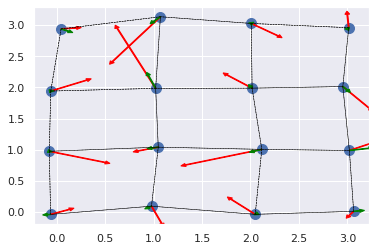

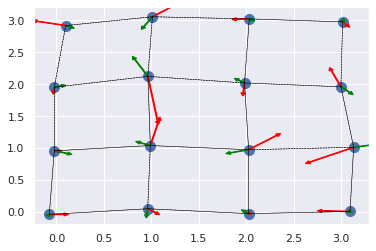

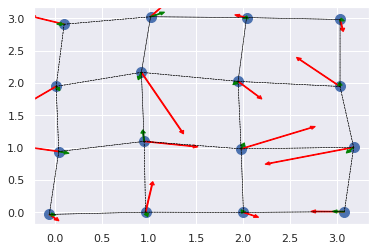

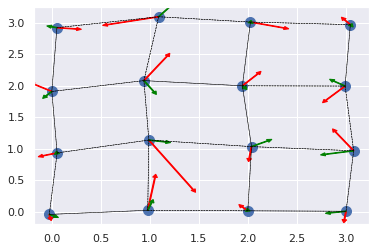

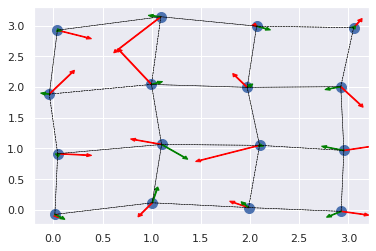

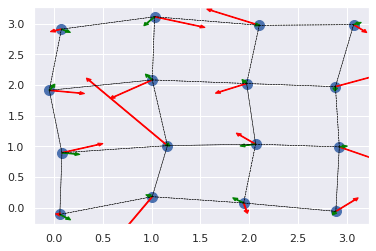

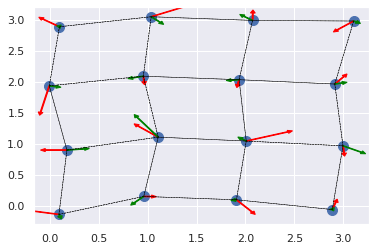

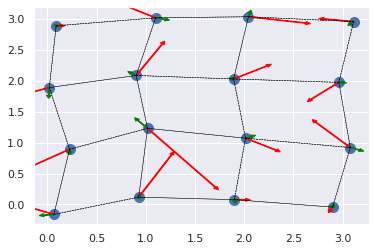

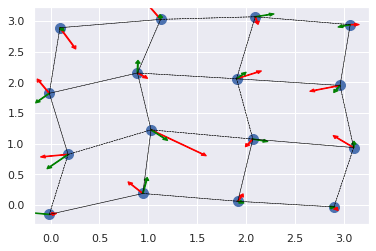

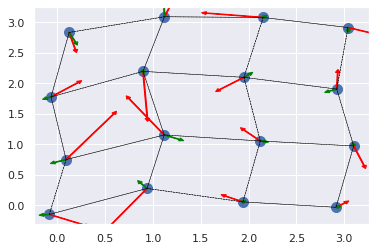

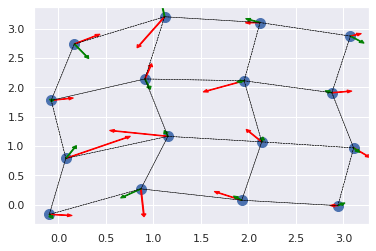

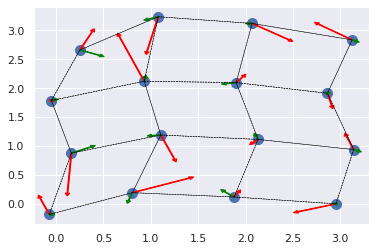

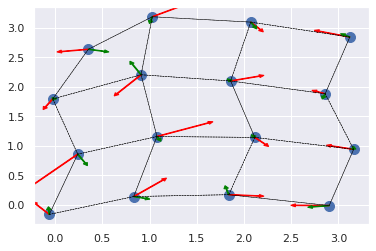

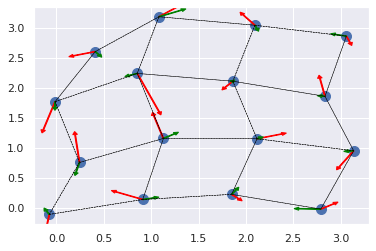

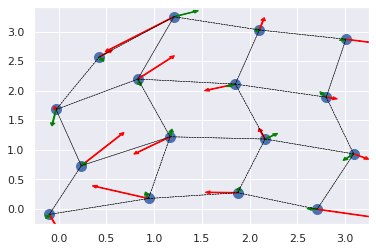

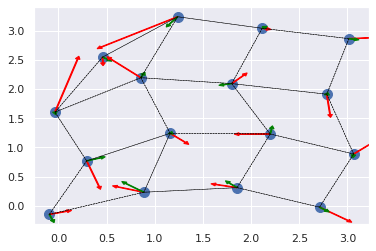

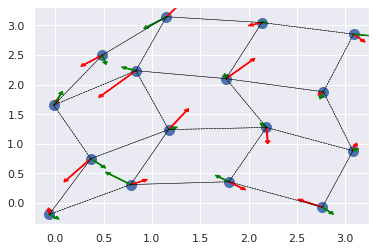

In [96]:
system_state = {}

energy_history = []
t_history = []

for i in pb(range(50000)):
    t = i*DT
    t_history.append(t)

    update_states(objs)
    energy_history.append(sum([obj.energy for obj in objs.values()]))
    if i % 2000 == 0:
        plot_objs_2d(objs)

    if i % 10 == 0:
        record_system_state(t, objs, system_state)

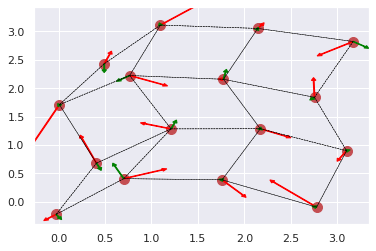

In [114]:
output_gif(system_state, objs, 'spring_dynamics_euler_calculated2.gif', fps=30)

Text(0.5, 0, 'time')

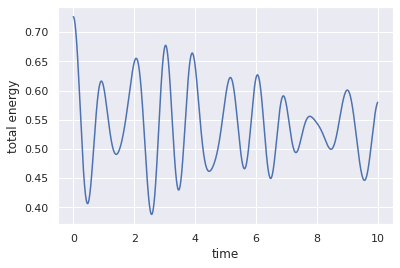

In [110]:
plt.plot(t_history, energy_history)
plt.ylabel('total energy')
plt.xlabel('time')

In [20]:
system_state.keys()

dict_keys(['t', 'objs'])

In [21]:
system_state['objs'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [22]:
system_state['objs'][0].keys()

dict_keys(['pos', 'vel', 'accel', 'force'])

In [107]:
system_state['objs'][0]['pos'][5]

array([-0.02558788,  0.01830044])

In [23]:
np.array(system_state['objs'][0]['pos']).shape

(5000, 2)

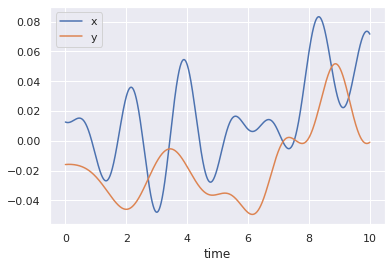

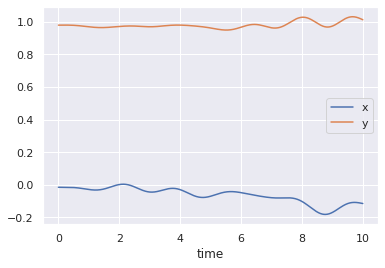

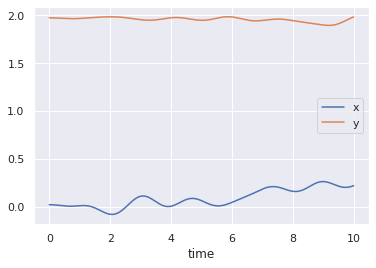

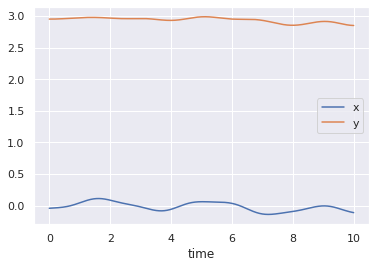

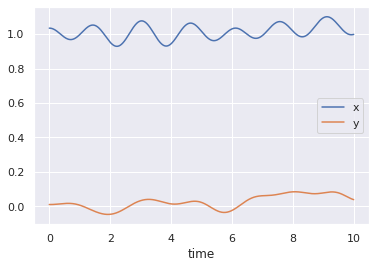

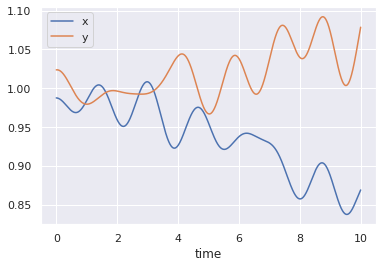

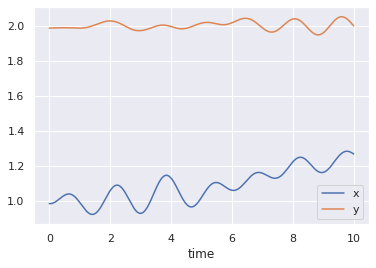

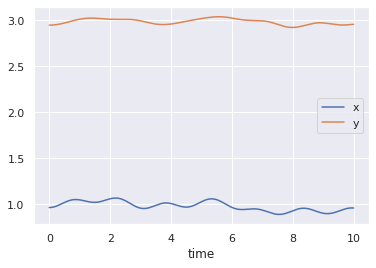

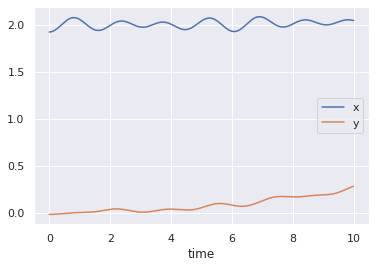

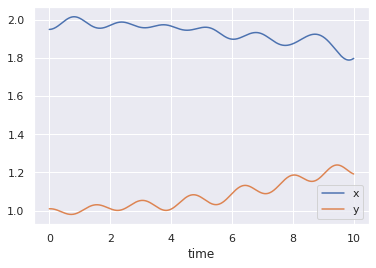

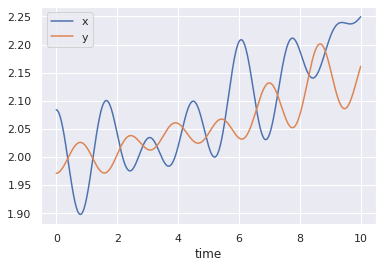

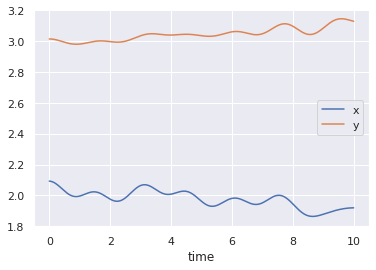

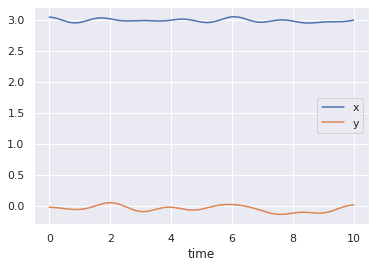

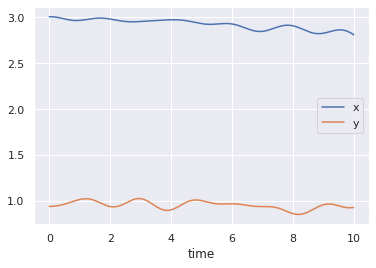

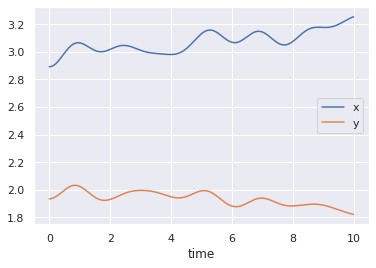

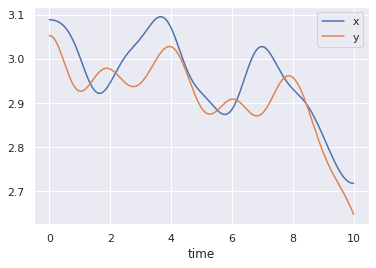

In [24]:
for i in range(16):
    plt.plot(system_state['t'], np.array(system_state['objs'][i]['pos'])[:, 0], label='x')
    plt.plot(system_state['t'], np.array(system_state['objs'][i]['pos'])[:, 1], label='y')
    plt.xlabel('time')
    plt.legend()
    plt.show()

In [3]:
!pip install torch-geometric
!pip install torch-scatter
!pip install torch-sparse
# !pip install torch-cluster

  Created wheel for torch-scatter: filename=torch_scatter-2.0.6-cp37-cp37m-linux_x86_64.whl size=292568 sha256=3623f448a5ebdf92443cabf96bed2ebc6fc878fd48a063d406efa98cc99cac0a
  Stored in directory: /root/.cache/pip/wheels/d6/bf/04/7c9e0c1466d37548e5c7c7c2daee2b7f90ce616f102c68bf07
Successfully built torch-scatter


In [1]:
import os
import time
from typing import List, Dict
import re
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np
from fastprogress import progress_bar as pb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from umap import UMAP
from sklearn.manifold import TSNE

In [2]:
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid(root='/tmp/Cora', name='Cora')
# from torch_geometric.data.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

RuntimeError: ignored

In [28]:
N_VEL_USE = 4  # 何時点前までの速度を使うか

In [48]:
from copy import deepcopy

def creaet_feats_outs_dataset(system_state, dim=2):

    feat_batch = []
    out_batch = []
    for t_idx in range(N_VEL_USE, len(system_state['t'])-N_VEL_USE-1):
        feats = []
        outs = []
        for obj_key in system_state['objs'].keys():
            feat = [system_state['objs'][obj_key]['pos'][t_idx][0], system_state['objs'][obj_key]['pos'][t_idx][1]]  # x(t), y(t)
            for i in range(N_VEL_USE):
                feat += [system_state['objs'][obj_key]['vel'][t_idx-i][0], system_state['objs'][obj_key]['vel'][t_idx-i][1]]  # vx(t), vy(t), vx(t-1), vy(t-1),...,vx(t-N_VEL_USE-1), vy(t-N_VEL_USE-1)
            feat += [system_state['objs'][obj_key]['accel'][t_idx][0], system_state['objs'][obj_key]['accel'][t_idx][1]]  # a(t), a(t)
            out = system_state['objs'][obj_key]['accel'][t_idx+1]-system_state['objs'][obj_key]['accel'][t_idx]  # a(t+1)-a(t)
            feats.append(torch.Tensor(feat))
            outs.append(torch.Tensor(out))
        feat_batch.append(torch.stack(feats))
        out_batch.append(torch.stack(outs))

    return torch.stack(feat_batch, axis=0), torch.stack(out_batch, axis=0)

In [307]:
feats, outs = creaet_feats_outs_dataset(system_state)

In [308]:
feats.shape  # (t, num_objs, feats_dim)

torch.Size([4991, 16, 12])

In [309]:
outs.shape  # (t, num_objs, accel_dim)

torch.Size([4991, 16, 2])

In [310]:
edge_index = {}
for obj in objs.values():
    for obj2 in obj.connected_objs:
        # edge_index[tuple(sorted((obj.idx, obj2.idx)))] = 1
        edge_index[(obj.idx, obj2.idx)] = 1

edge_index = list(edge_index.keys())

In [311]:
edge_index

[(0, 4),
 (0, 1),
 (1, 5),
 (1, 0),
 (1, 2),
 (2, 6),
 (2, 1),
 (2, 3),
 (3, 7),
 (3, 2),
 (4, 0),
 (4, 8),
 (4, 5),
 (5, 1),
 (5, 9),
 (5, 4),
 (5, 6),
 (6, 2),
 (6, 10),
 (6, 5),
 (6, 7),
 (7, 3),
 (7, 11),
 (7, 6),
 (8, 4),
 (8, 12),
 (8, 9),
 (9, 5),
 (9, 13),
 (9, 8),
 (9, 10),
 (10, 6),
 (10, 14),
 (10, 9),
 (10, 11),
 (11, 7),
 (11, 15),
 (11, 10),
 (12, 8),
 (12, 13),
 (13, 9),
 (13, 12),
 (13, 14),
 (14, 10),
 (14, 13),
 (14, 15),
 (15, 11),
 (15, 14)]

In [312]:
 edge_index = torch.tensor(edge_index).T

In [313]:
edge_index.shape

torch.Size([2, 48])

In [314]:
FEATURE_DIM = feats.shape[2]

In [315]:
GCNConv(FEATURE_DIM, 16)(feats, edge_index).shape

torch.Size([4991, 16, 16])

In [374]:
class GNNModule(torch.nn.Module):
    def __init__(self, n_features, out_dim, intermediate_dim=24):
        super(GNNModule, self).__init__()
        self.conv1 = GCNConv(n_features, intermediate_dim)
        self.conv2 = GCNConv(intermediate_dim, out_dim)

    def forward(self, x, edge_index):
        x2 = self.conv1(x, edge_index)
        x3 = F.relu(x2)
        x4 = F.dropout(x3, training=self.training)
        x5 = self.conv2(x4, edge_index)
        return x5

In [317]:
GNNModule(FEATURE_DIM, 2)(feats, edge_index)[0].shape

torch.Size([16, 2])

In [329]:
class SpringDynamicsNet(torch.nn.Module):

    def __init__(self, n_features, out_dim, n_gnn_module=4, intermediate_dim=24):
        super(SpringDynamicsNet, self).__init__()
        self._intermediate_gnn_modules = nn.Sequential(
            *[GNNModule(n_features, n_features) for _ in range(n_gnn_module)]
        )
        self._fc = nn.Linear(n_features, out_dim)

    def forward(self, x, edge_index):
        for sping_module in self._intermediate_gnn_modules:
            residual = x
            gnn_out = sping_module(x, edge_index)
            x = residual + gnn_out
        return self._fc(x)

In [353]:
spring_dynamics_net = SpringDynamicsNet(
    n_features=FEATURE_DIM,
    out_dim=2,
    n_gnn_module=4,
    intermediate_dim=24
)

In [354]:
spring_dynamics_net

SpringDynamicsNet(
  (_intermediate_sping_modules): Sequential(
    (0): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
    (1): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
    (2): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
    (3): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
  )
  (_fc): Linear(in_features=12, out_features=2, bias=True)
)

In [355]:
pred = spring_dynamics_net(feats, edge_index) 

In [356]:
pred.shape  # (batch_size, n_nodes, out_dim)

torch.Size([4991, 16, 2])

In [357]:
outs.shape

torch.Size([4991, 16, 2])

In [358]:
spring_dynamics_net = SpringDynamicsNet(
    n_features=FEATURE_DIM,
    out_dim=2,
    n_gnn_module=4,
    intermediate_dim=24
)

In [359]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(spring_dynamics_net.parameters(), lr=0.01, weight_decay=5e-4)

In [360]:
criterion(outs, pred)

tensor(1.8131, grad_fn=<MseLossBackward>)

In [361]:
BATCH_SIZE = 32
N_EPOCHS = 20

In [362]:
feats, outs = creaet_feats_outs_dataset(system_state)

In [363]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
spring_dynamics_net.to(device)
spring_dynamics_net.train()

loss_histroy = []

for epoch in pb(range(N_EPOCHS)):
    epoch_loss = 0
    for i in range(feats.shape[0]//BATCH_SIZE):
        feat_batch = feats[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        out_batch = outs[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        optimizer.zero_grad()
        preds = spring_dynamics_net(feat_batch, edge_index) 
        loss = criterion(out_batch, preds)
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss.item()*feat_batch.shape[0]
    loss_histroy.append(epoch_loss)

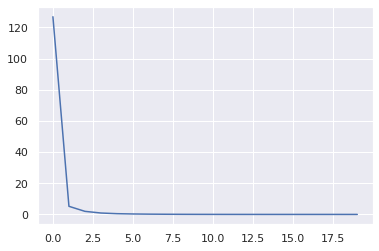

In [364]:
plt.plot(loss_histroy)

In [367]:
pred_feats = []

for obj_key in system_state['objs'].keys():
    feat = [system_state['objs'][obj_key]['pos'][-1][0], system_state['objs'][obj_key]['pos'][-1][1]]  # x(t), y(t)
    for i in range(N_VEL_USE):
        feat += [system_state['objs'][obj_key]['vel'][-1-i][0], system_state['objs'][obj_key]['vel'][-1-i][1]]  # vx(t), vy(t), vx(t-1), vy(t-1),...,vx(t-N_VEL_USE-1), vy(t-N_VEL_USE-1)
    feat += [system_state['objs'][obj_key]['accel'][-1][0], system_state['objs'][obj_key]['accel'][-1][1]]  # a(t), a(t)

    pred_feats.append(torch.Tensor(feat))


In [368]:
spring_dynamics_net.eval()

SpringDynamicsNet(
  (_intermediate_sping_modules): Sequential(
    (0): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
    (1): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
    (2): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
    (3): GNNModule(
      (conv1): GCNConv(12, 24)
      (conv2): GCNConv(24, 12)
    )
  )
  (_fc): Linear(in_features=12, out_features=2, bias=True)
)

In [372]:
torch.stack(pred_feats).unsqueeze(0).shape

torch.Size([1, 16, 12])

In [373]:
spring_dynamics_net(torch.stack(pred_feats).unsqueeze(0), edge_index)

tensor([[[-0.0014, -0.0014],
         [ 0.0024,  0.0002],
         [ 0.0022,  0.0014],
         [-0.0016,  0.0004],
         [ 0.0022, -0.0003],
         [-0.0027, -0.0024],
         [-0.0025,  0.0025],
         [ 0.0031, -0.0029],
         [ 0.0006, -0.0011],
         [ 0.0003,  0.0040],
         [ 0.0033, -0.0045],
         [-0.0033,  0.0030],
         [-0.0012,  0.0002],
         [ 0.0006, -0.0021],
         [-0.0023,  0.0021],
         [ 0.0008,  0.0004]]], grad_fn=<AddBackward0>)

In [370]:
pred_feats

[tensor([ 0.0100, -0.0550,  0.0270,  0.0914,  0.0272,  0.0908,  0.0273,  0.0902,
          0.0274,  0.0895, -0.0674,  0.3074]),
 tensor([ 0.0882,  1.0078, -0.0817, -0.0102, -0.0812, -0.0095, -0.0807, -0.0089,
         -0.0803, -0.0083, -0.2296, -0.3094]),
 tensor([ 0.0832,  2.0201, -0.0803, -0.0816, -0.0797, -0.0809, -0.0791, -0.0802,
         -0.0785, -0.0795, -0.2968, -0.3522]),
 tensor([-0.0882,  2.9546,  0.0184, -0.0432,  0.0177, -0.0438,  0.0169, -0.0444,
          0.0162, -0.0450,  0.3801,  0.3095]),
 tensor([ 0.9680,  0.1572, -0.0811,  0.0340, -0.0810,  0.0334, -0.0810,  0.0328,
         -0.0809,  0.0323, -0.0254,  0.2887]),
 tensor([ 1.0258,  1.2049,  0.0982,  0.1259,  0.0972,  0.1271,  0.0963,  0.1282,
          0.0953,  0.1294,  0.4941, -0.5928]),
 tensor([ 1.0061,  2.1425,  0.0598, -0.0958,  0.0586, -0.0962,  0.0574, -0.0966,
          0.0562, -0.0969,  0.5938,  0.1904]),
 tensor([ 0.9856,  3.1166, -0.0997,  0.0617, -0.0983,  0.0615, -0.0970,  0.0614,
         -0.0956,  0.06